# Step 1: Load the Dataset

In [1]:
import cv2 
import pandas as pd
import glob
# Load image data in batches
batch_size = 10
image_files = glob.glob(r"C:\Users\jayapriya\OneDrive\Desktop\intel\cars_train")
# Load dataset(csv)
data = pd.read_csv(r"C:\Users\jayapriya\OneDrive\Desktop\intel\train image dataset.csv")

# Step 2: Data Preprocessing

In [2]:
import cv2 
import os
# Process images in batches
for i in range(0, len(image_files), batch_size):
    batch_images = [cv2.imread(file) for file in image_files[i:i+batch_size]]
    # Process or analyze batch_images here
    print(f"Processed batch {i+1} to {min(i+batch_size, len(image_files))}")



Processed batch 1 to 1


# Step 3: Exploratory Data Analysis (EDA)

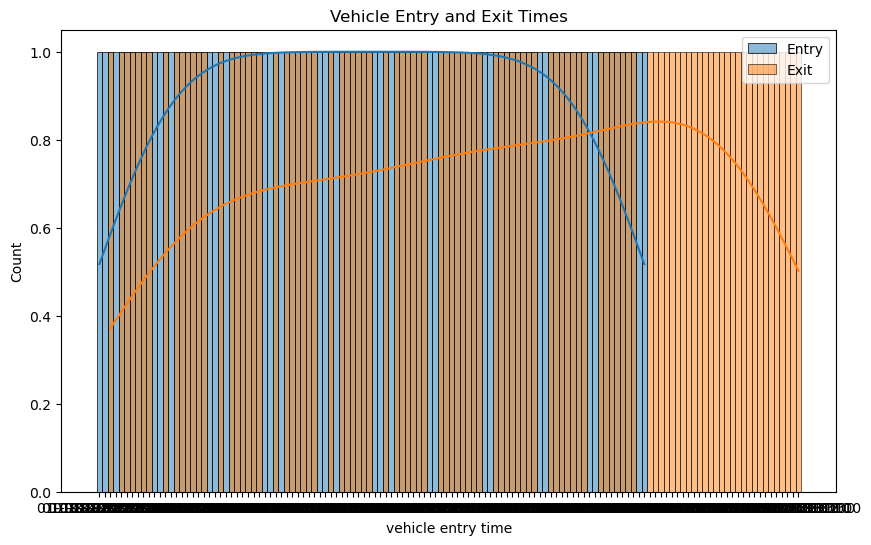

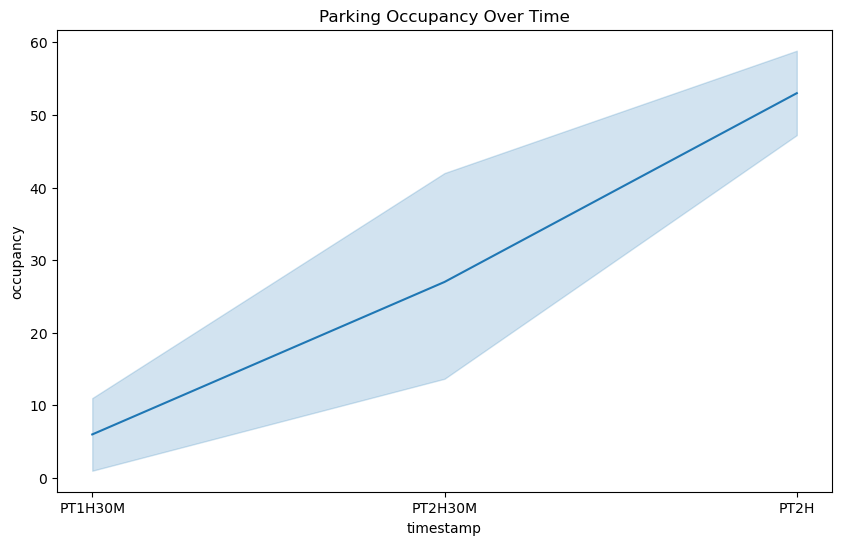

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Handle missing values in dataset
data.fillna(method='ffill', inplace=True)

# Plot vehicle entry and exit times
plt.figure(figsize=(10,6))
sns.histplot(data['vehicle entry time'], kde=True, label='Entry')
sns.histplot(data['vehicle exit time'], kde=True, label='Exit')
plt.legend()
plt.title('Vehicle Entry and Exit Times')
plt.show()

# Plot parking occupancy trends
plt.figure(figsize=(10,6))
sns.lineplot(x='timestamp', y='occupancy', data=data)
plt.title('Parking Occupancy Over Time')
plt.show()

# Step 4: Vehicle Matching

In [4]:
!pip install pytesseract
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
import pandas as pd
from PIL import Image, ImageEnhance
import os

# Define the folder path containing the preprocessed images
image_folder = r"C:\Users\jayapriya\OneDrive\Desktop\intel\license_plates_detection_train"

# Define the OCR settings
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
ocr_config = r'--psm 7 -l eng'

# Get a list of all image files in the folder
preprocessed_images = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('.jpg', '.png', '.tif', '.bmp'))]

# Perform OCR on the images
license_plates = [pytesseract.image_to_string(Image.open(img)) for img in preprocessed_images]
license_plates = []
for img_path in preprocessed_images:
    # Load the image and enhance it
    img = Image.open(img_path)
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2.0)

    # Perform OCR on the image
    plate = pytesseract.image_to_string(img, config=ocr_config)
    license_plates.append(plate)

# Load the approved vehicles database from a CSV file
approved_vehicles = pd.read_csv(r"C:\Users\jayapriya\OneDrive\Desktop\intel\Licplatesrecognition_train.csv")


# Match license plates to the approved database
matches = [plate for plate in license_plates if plate in approved_vehicles['license_plate'].values]


# Step 5: Insight Generation

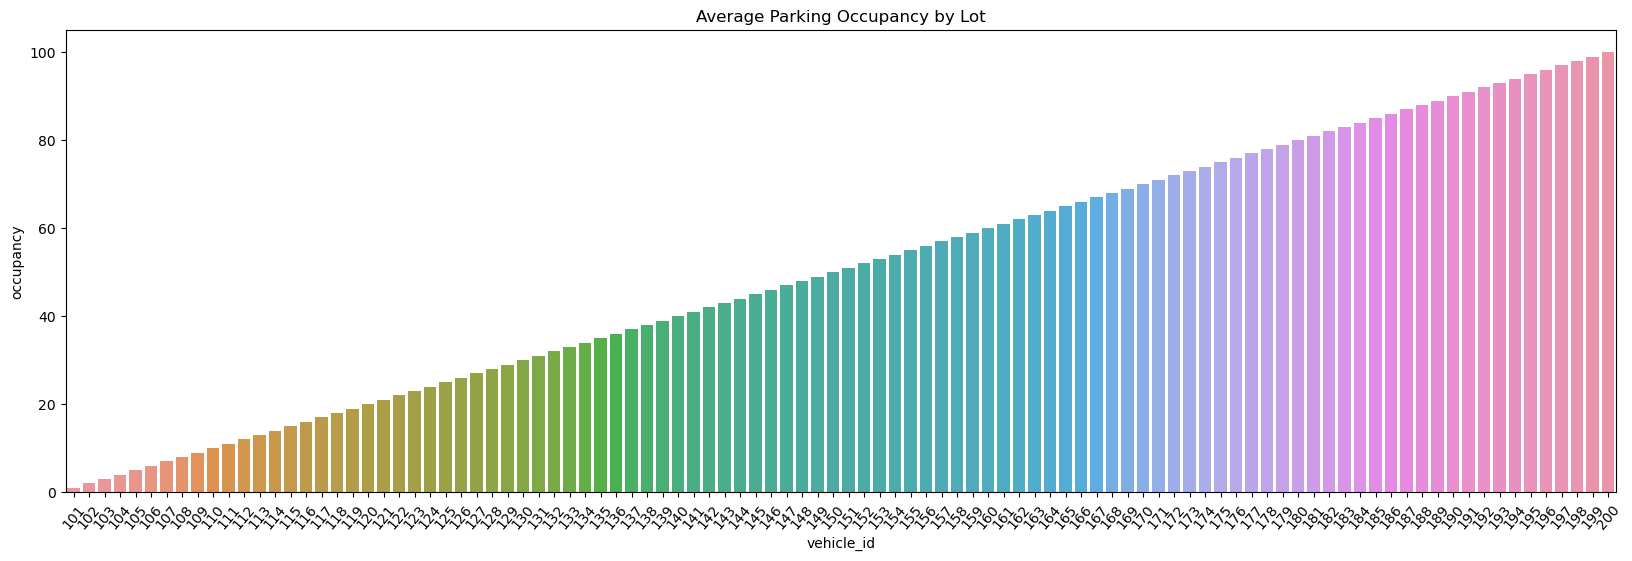

In [5]:

import pandas as pd

# Load dataset(csv)
data = pd.read_csv(r"C:\Users\jayapriya\OneDrive\Desktop\intel\train image dataset.csv")

# Now you can use the data variable
movement_patterns = data.groupby('vehicle_id').agg({'vehicle entry time': 'min', 'vehicle exit time': 'max'})

# Convert 'exit_time' and 'entry_time' to datetime format
movement_patterns['vehicle exit time'] = pd.to_datetime(movement_patterns['vehicle exit time'])
movement_patterns['vehicle entry time'] = pd.to_datetime(movement_patterns['vehicle entry time'])

# Calculate the duration
movement_patterns['duration'] = movement_patterns['vehicle exit time'] - movement_patterns['vehicle entry time']

# Generate insights on parking occupancy
parking_insights = data.groupby('vehicle_id').agg({'occupancy': 'mean'}).reset_index()

# Visualize insights
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,6))
plt.xticks(rotation=50)
sns.barplot(x='vehicle_id', y='occupancy', data=parking_insights)
plt.title('Average Parking Occupancy by Lot')
plt.show()

# Step 6: Implementing the Solution in a Scalable Manner

In [6]:
from tensorflow.keras import layers, models

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(224 * 224, activation='sigmoid'),
        layers.Reshape((224, 224, 1))
    ])
    return model

model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.save("vehicle_model.h5")

In [7]:
import tensorflow as tf
from tensorflow import lite
# Convert model to TensorFlow Lite
model = tf.keras.models.load_model('vehicle_model.h5')
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model
with open('vehicle_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\jayapriya\AppData\Local\Temp\tmp70vuz0vp\assets


INFO:tensorflow:Assets written to: C:\Users\jayapriya\AppData\Local\Temp\tmp70vuz0vp\assets


# Step 7: Creating a User-friendly Interface


In [3]:
from flask import Flask, render_template, request
import cv2
import pandas as pd
import pytesseract

app = Flask(__name__)

# Load the approved vehicles database from a CSV file
approved_vehicles = pd.read_csv(r"C:\Users\jayapriya\OneDrive\Desktop\intel\Licplatesrecognition_train.csv")

from IPython.display import HTML

html_code = """
<!DOCTYPE html>
<html>
  <head>
    <title>License Plate Recognition</title>
  </head>
  <body>
    <h1>Upload a License Plate Image</h1>
    <form action="/process" method="post" enctype="multipart/form-data">
      <input type="file" name="image">
      <button type="submit">Process</button>
    </form>
  </body>
</html>
"""

HTML(html_code)

# Define a route for the homepage
@app.route('/')
def home():
    return render_template('index.html')

# Define a route for processing the license plate image
@app.route('/process', methods=['POST'])
def process_image():
    # Get the uploaded image
    image = request.files['image']

    # Perform OCR on the image
    plate = pytesseract.image_to_string(Image.open(image), config=ocr_config)

    # Match the license plate to the approved database
    match = [plate for plate in approved_vehicles['license_plate'].values if plate == plate]

    # Return the result
    return render_template('result.html', plate=plate, match=match)

if __name__ == '__main__':
    app.run(port=5001)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
[2024-07-15 13:27:11,575] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "C:\Users\jayapriya\anaconda\lib\site-packages\flask\app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\jayapriya\anaconda\lib\site-packages\flask\app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\jayapriya\anaconda\lib\site-packages\flask\app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\jayapriya\anaconda\lib\site-packages\flask\app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "C:\Users\jayapriya\AppData\Local\Temp\ipykernel_1924\2450764238.py", line 34, in home
    return render_template('index.html')
  File "C:\Users\jayapriya\anaconda\lib\site-packages\flask\templating.py", line 146, in render_template
    template